In [1]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

from metrics import get_acc, get_jsd, get_auc, add_preds, acc_buckets, get_kappa_mcqs, get_diffp, populate_preds, precomputed_accs, precomputed_diffs
# Wrap the original function
original_get_kappa_mcqs = get_kappa_mcqs

# Redefine get_kappa_mcqs to always include n_options=2
def get_kappa_mcqs(*args, **kwargs):
    return original_get_kappa_mcqs(*args, n_options=2, **kwargs)

/is/sg2/sgoel/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preds_dict = {}

folder_name = "epochs_3"
model_names = ["weak_ft", "strong_base", "w2s", "strong_ft"]
skip_list = []
#iterate over folder names with ___ in results/{folder_name}
for dir in os.listdir(f"results/{folder_name}"):
    dir_path = f"results/{folder_name}/{dir}"
    if os.path.isdir(dir_path) and "___" in dir:
        weak_model, strong_model = dir.split("___")
        print(f"Models: {weak_model}, {strong_model}")
        datasets = os.listdir(dir_path)
        datasplits = ["test"]
        preds = {}
        preds = populate_preds(preds, datasets, model_names, datasplits, folder_name, weak_model, strong_model)
        preds_dict[(weak_model, strong_model)] = preds        
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "sciq", "piqa", "sst2", "twitter-sentiment"]

Models: Llama-3.1-8B, Llama-3.1-8B
Error loading hellaswag predictions for (Llama-3.1-8B, Llama-3.1-8B)
Models: Qwen2.5-0.5B, Llama-3.1-8B
Error loading hellaswag predictions for (Qwen2.5-0.5B, Llama-3.1-8B)
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.1-8B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: gemma-2-9b, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


In [7]:
# Updated loop to handle legend-based R^2 values
skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B")]
diffs_test = {}

for metric_func, metric_name in zip([get_jsd, get_kappa_mcqs, get_diffp, _, _], ["JSD", "Kappa", "Prediction Diff%", "Accuracy Gap", "Mag Accuracy Gap"]):
    diffs_test[metric_name] = {}
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        if "Accuracy Gap" in metric_name:
            acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
            diffs_test[metric_name][(weak_model, strong_model)] = {dset: acc_test[dset]["strong_base"] - acc_test[dset]["weak_ft"] for dset in datasets}
            if "Mag" in metric_name:
                diffs_test[metric_name][(weak_model, strong_model)] = {dset: np.abs(v) for dset, v in diffs_test[metric_name][(weak_model, strong_model)].items()}
            continue
        diffs_test[metric_name][(weak_model, strong_model)] = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, "test", metric_func, metric_name) for dset in datasets}

# Flatten the diffs_test dictionary
flattened_data = []
for metric, model_data in diffs_test.items():
    for (weak_model, strong_model), dataset_values in model_data.items():
        for dataset, value in dataset_values.items():
            flattened_data.append({
                "Metric": metric,
                "Weak_Model": weak_model,
                "Strong_Model": strong_model,
                "Dataset": dataset,
                "Value": value
            })

# Convert to DataFrame
df = pd.DataFrame(flattened_data)
# Pivot table to align metrics
pivot_df = df.pivot_table(index=["Weak_Model", "Strong_Model", "Dataset"], 
                          columns="Metric", values="Value")
print(pivot_df)
# Compute correlation matrix
correlation_matrix = pivot_df.corr()

# Display the correlation matrix
correlation_matrix

Metric                                           Accuracy Gap       JSD  \
Weak_Model   Strong_Model Dataset                                         
Llama-3.2-1B Llama-3.1-8B anli-r2                  -10.778443  0.385144   
                          boolq                    -14.834276  0.340254   
                          cola                      -9.937888  0.311461   
                          ethics-utilitarianism     -6.265002  0.383621   
                          piqa                      -4.148472  0.252835   
...                                                       ...       ...   
phi-2        gemma-2-9b   ethics-utilitarianism    -11.449832  0.362918   
                          piqa                      -5.676856  0.187016   
                          sciq                       1.006711  0.221304   
                          sst2                      -5.373832  0.262472   
                          twitter-sentiment         -1.140000  0.202936   

Metric                  

Metric,Accuracy Gap,JSD,Kappa,Mag Accuracy Gap,Prediction Diff%
Metric,,,,,
Accuracy Gap,1.000000,-0.411984,0.285962,-0.553820,-0.187792
JSD,-0.411984,1.000000,-0.277030,0.580148,0.219428
Kappa,0.285962,-0.277030,1.000000,-0.343433,-0.844669
Mag Accuracy Gap,-0.553820,0.580148,-0.343433,1.000000,0.397055
Prediction Diff%,-0.187792,0.219428,-0.844669,0.397055,1.000000


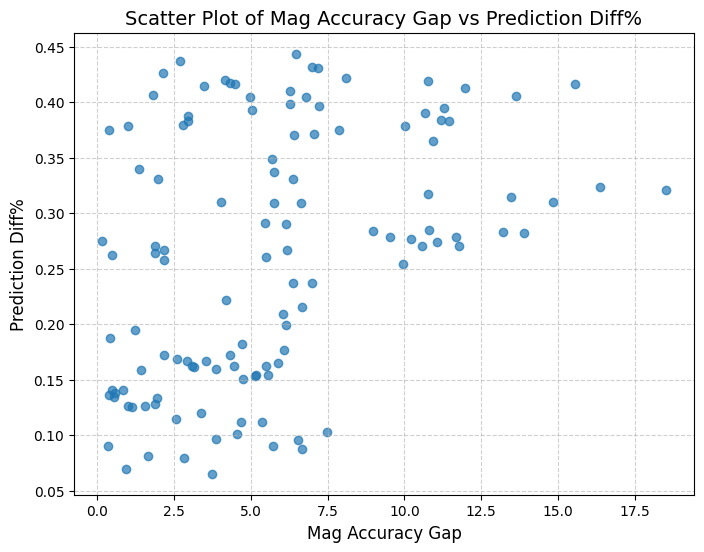

In [8]:
metric_x = 'Mag Accuracy Gap'  # Replace with the desired metric from your data
metric_y = 'Prediction Diff%'  # Replace with the desired metric from your data

# Drop rows with missing values for the selected metrics
filtered_data = pivot_df[[metric_x, metric_y]].dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data[metric_x], filtered_data[metric_y], alpha=0.7)
plt.title(f"Scatter Plot of {metric_x} vs {metric_y}", fontsize=14)
plt.xlabel(metric_x, fontsize=12)
plt.ylabel(metric_y, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
def make_clean_scatter_plot_datasets(diff, w2sgain, labels, diff_func_name, weak_models, strong_models, model_short_form, annotate_modelpairs=False):
    df = pd.DataFrame({
        'Difference': diff,
        'W2SGain': w2sgain,
        'Label': labels,
        'WeakModel': weak_models,
        'StrongModel': strong_models
    })
    plt.figure(figsize=(12, 8))

    # Initialize dictionary to store R^2 values
    r2_dict = {}

    # Create a scatter plot with trend lines for each dataset
    scatter = sns.scatterplot(
        data=df,
        x='Difference',
        y='W2SGain',
        hue='Label',
        palette='tab10',
        s=100,
        alpha=0.8,
        edgecolor='w',
        linewidth=0.5
    )

    # Add a linear fit line and calculate R^2
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        sns.regplot(data=label_df, x='Difference', y='W2SGain', scatter=False, ci=None, line_kws={'linestyle': '--'})
        
        # Compute R^2
        X = label_df['Difference'].values.reshape(-1, 1)
        y = label_df['W2SGain'].values
        reg = LinearRegression().fit(X, y)
        r2 = reg.score(X, y)
        correlation = 'Positive' if reg.coef_[0] > 0 else 'Negative'
        r2_dict[label] = f"{correlation} (R²={r2:.2f})"

    # Annotate points with model short form and size
    if annotate_modelpairs:
        for i in range(len(df)):
            weak_model = df['WeakModel'].iloc[i]
            strong_model = df['StrongModel'].iloc[i]
            weak_short = model_short_form[weak_model]
            strong_short = model_short_form[strong_model]
            annotation = f"{weak_short}_{strong_short}"
            plt.text(
                df['Difference'].iloc[i],
                df['W2SGain'].iloc[i] + 0.1,  # Slight offset
                annotation,
                fontsize=9,
                ha='center',
                va='bottom'
            )

    # Update legend to include R^2 and correlation
    handles, labels = scatter.get_legend_handles_labels()
    new_labels = [f"{label}: {r2_dict[label]}" for label in labels]
    plt.legend(
        handles=handles,
        labels=new_labels,
        title='Dataset (with R²)',
        fontsize=10,
        title_fontsize=13,
        loc='best'
    )

    # Labels and title
    plt.xlabel(f"{diff_func_name} between weak_ft and strong_base", fontsize=14)
    plt.ylabel("Accuracy Gain of w2s over weak_ft", fontsize=14)
    plt.title(f"Accuracy Gain of w2s vs. {diff_func_name} between weak_ft and strong_base", fontsize=16)

    # Add grid and display
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def scatter_diff_w2sgain_datasets(accs, diffs, datasets, m_weak, m_strong_base, m_w2s, m_strong_ft, pgr=False, w2sgain=[], diff=[], labels=[], weak_models=[], strong_models=[], accuracy_gap=[], weak_model_name="", strong_model_name=""):
    for dset in datasets:
        metric_num = accs[dset][m_w2s] - accs[dset][m_weak]
        if pgr:
            metric_denom = accs[dset][m_strong_ft] - accs[dset][m_weak]
            if metric_denom != 0:
                metric_num /= metric_denom
            else:
                metric_num = 0
        w2sgain.append(metric_num)
        diff.append(diffs[dset])
        labels.append(dset)
        weak_models.append(weak_model_name)  # Append the actual weak model name
        strong_models.append(strong_model_name)  # Append the actual strong model name
        # Collect AccuracyGap
        accuracy_gap_value = accs[dset][m_strong_base] - accs[dset][m_weak]
        accuracy_gap.append(accuracy_gap_value)
    return w2sgain, diff, labels, weak_models, strong_models, accuracy_gap

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B
R-squared: 0.00013276215138779968
anli-r2 regression coefficient is 0.0022, with positive relationship with 'W2SGain'.
R-squared: 0.7110075606161664
boolq regression coefficient is 0.3432, with positive relationship with 'W2SGain'.
R-squared: 0.7329929088900152
cola regression coefficient is 0.7119, with positive relationship with 'W2SGain'.
R-squared: 0.7677436926792891
ethics-utilitarianism regression coefficient is 0.4323, with positive relationship with 'W2SGain'.
R-squared: 0.5274671410963105
sciq regression coeffi

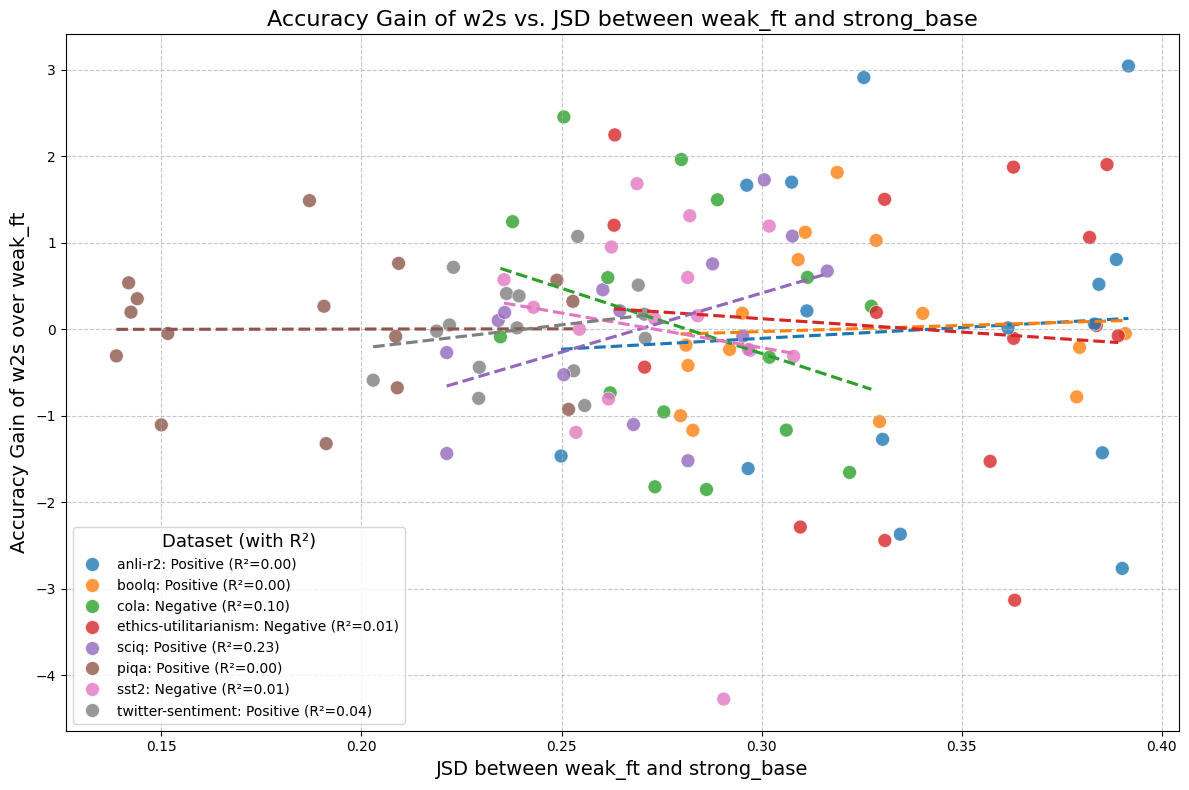

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B
R-squared: 0.00013276215138779968
anli-r2 regression coefficient is 0.0022, with positive relationship with 'W2SGain'.
R-squared: 0.7110075606161664
boolq regression coefficient is 0.3432, with positive relationship with 'W2SGain'.
R-squared: 0.7329929088900152
cola regression coefficient is 0.7119, with positive relationship with 'W2SGain'.
R-squared: 0.7677436926792891
ethics-utilitarianism regression coefficient is 0.4323, with positive relationship with 'W2SGain'.
R-squared: 0.5274671410963105
sciq regression coeffi

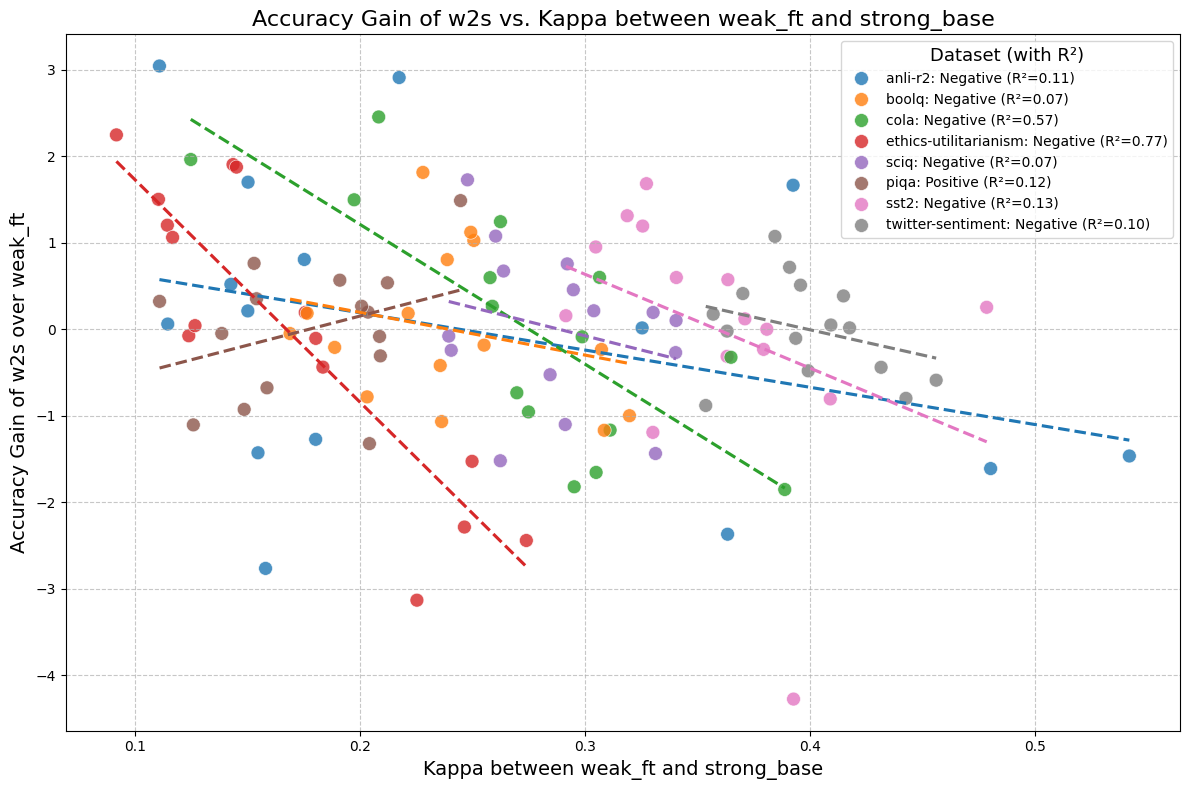

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B
R-squared: 0.00013276215138779968
anli-r2 regression coefficient is 0.0022, with positive relationship with 'W2SGain'.
R-squared: 0.7110075606161664
boolq regression coefficient is 0.3432, with positive relationship with 'W2SGain'.
R-squared: 0.7329929088900152
cola regression coefficient is 0.7119, with positive relationship with 'W2SGain'.
R-squared: 0.7677436926792891
ethics-utilitarianism regression coefficient is 0.4323, with positive relationship with 'W2SGain'.
R-squared: 0.5274671410963105
sciq regression coeffi

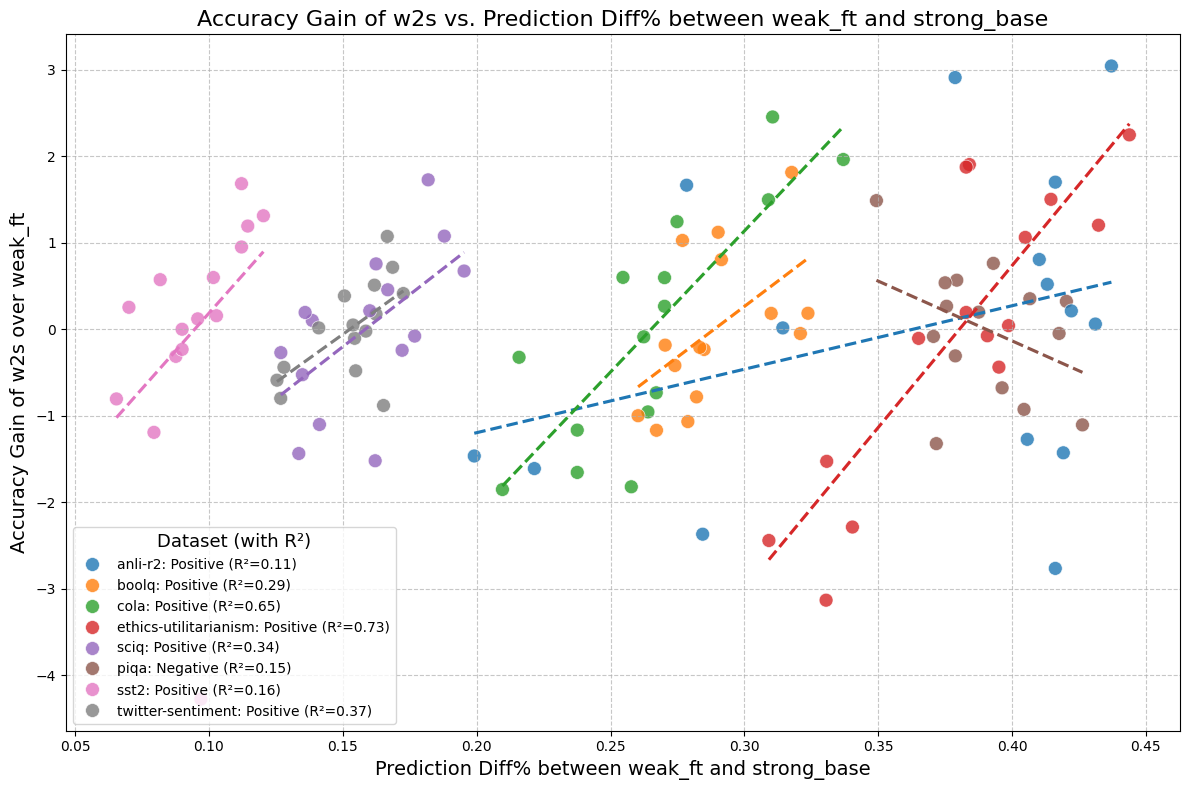

In [33]:
model_short_form = {
    "Llama-3.1-8B": "L.1-8",
    "gemma-2-9b": "G-9",
    "phi-2": "P-2.7",
    "gemma-2-2b": "G-2",
    "Qwen2.5-7B": "Q-7",
    "Llama-3.2-1B": "L.2-1",
    "Qwen2.5-0.5B": "Q-0.5",
    "SmolLM-1.7B": "S-1.7",
    # Add more models as needed
}

skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B")]

# Main loop
for metric_func, metric_name in zip([get_jsd, get_kappa_mcqs, get_diffp], ["JSD", "Kappa", "Prediction Diff%"]):
    w2sgain, diff, labels, weak_models, strong_models, accuracy_gap, acc_gap_precomp = [], [], [], [], [], [], []
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        print(f"Models: {weak_model}, {strong_model}")
        acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
        w2sgain, diff, labels, weak_models, strong_models, accuracy_gap = scatter_diff_w2sgain_datasets(
            acc_test, diffs_test[metric_name][(weak_model, strong_model)], datasets, "weak_ft", "strong_base", "w2s", "strong_ft", False, w2sgain, diff, labels, weak_models, strong_models, accuracy_gap, weak_model_name=weak_model, strong_model_name=strong_model
        )

    # Create DataFrame
    df = pd.DataFrame({
        'Difference': diff,
        'W2SGain': w2sgain,
        'Label': labels,
        'WeakModel': weak_models,
        'StrongModel': strong_models,
        'AccuracyGap': accuracy_gap
    })

    # Initialize Residuals column
    df['Residuals'] = np.nan

    # Compute residuals per dataset
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        if len(label_df) < 2:
            print(f"Skipping {label} due to insufficient data points.")
            continue  # Skip if not enough data points
        X = label_df[['AccuracyGap']]
        y = label_df['W2SGain']
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)
        r2 = reg.score(X, y)
        print("R-squared:", r2)
        coefficient = reg.coef_[0]
        if coefficient > 0:
            sign = "positive"
        elif coefficient < 0:
            sign = "negative"
        else:
            sign = "zero"
        print(f"{label} regression coefficient is {coefficient:.4f}, with {sign} relationship with 'W2SGain'.")
        residuals = y - y_pred
        df.loc[df['Label'] == label, 'Residuals'] = residuals

    # Call the plotting function with residuals
    make_clean_scatter_plot_datasets(
        df['Difference'].tolist(),
        df['Residuals'].tolist(),
        df['Label'].tolist(),
        metric_name,
        df['WeakModel'].tolist(),
        df['StrongModel'].tolist(),
        model_short_form
    )

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


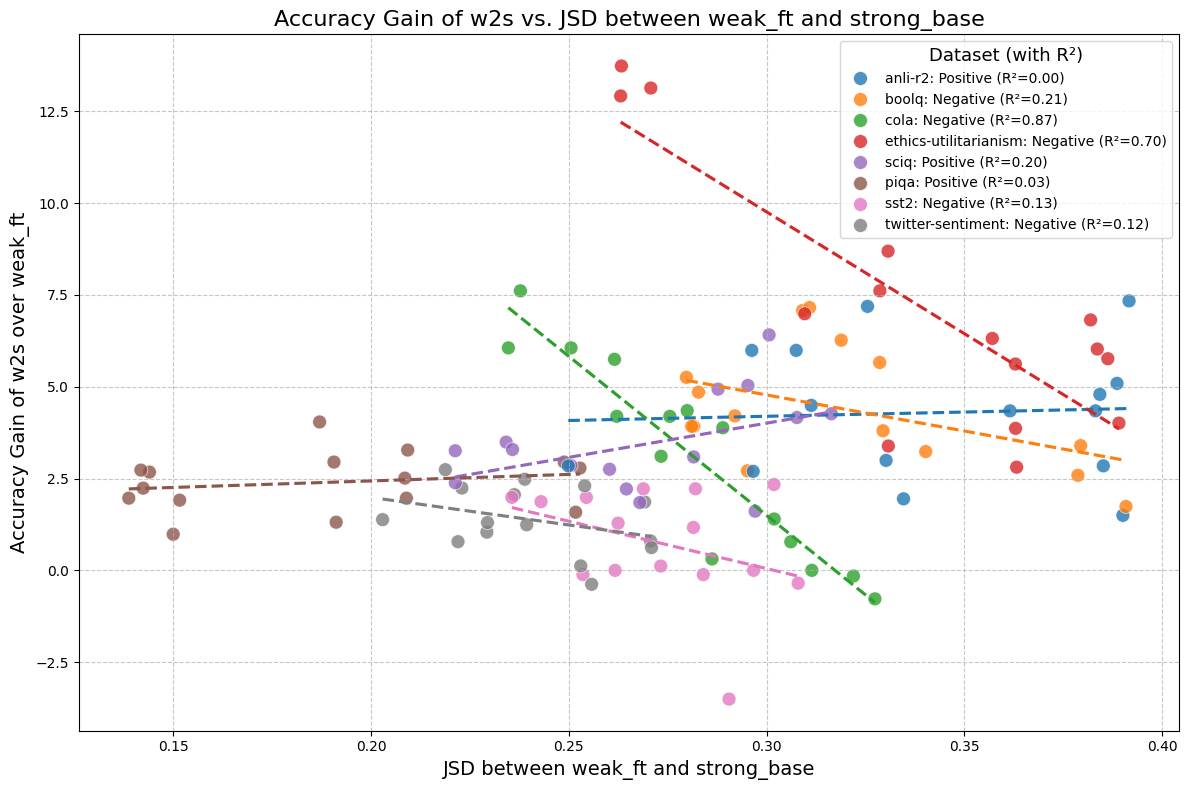

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


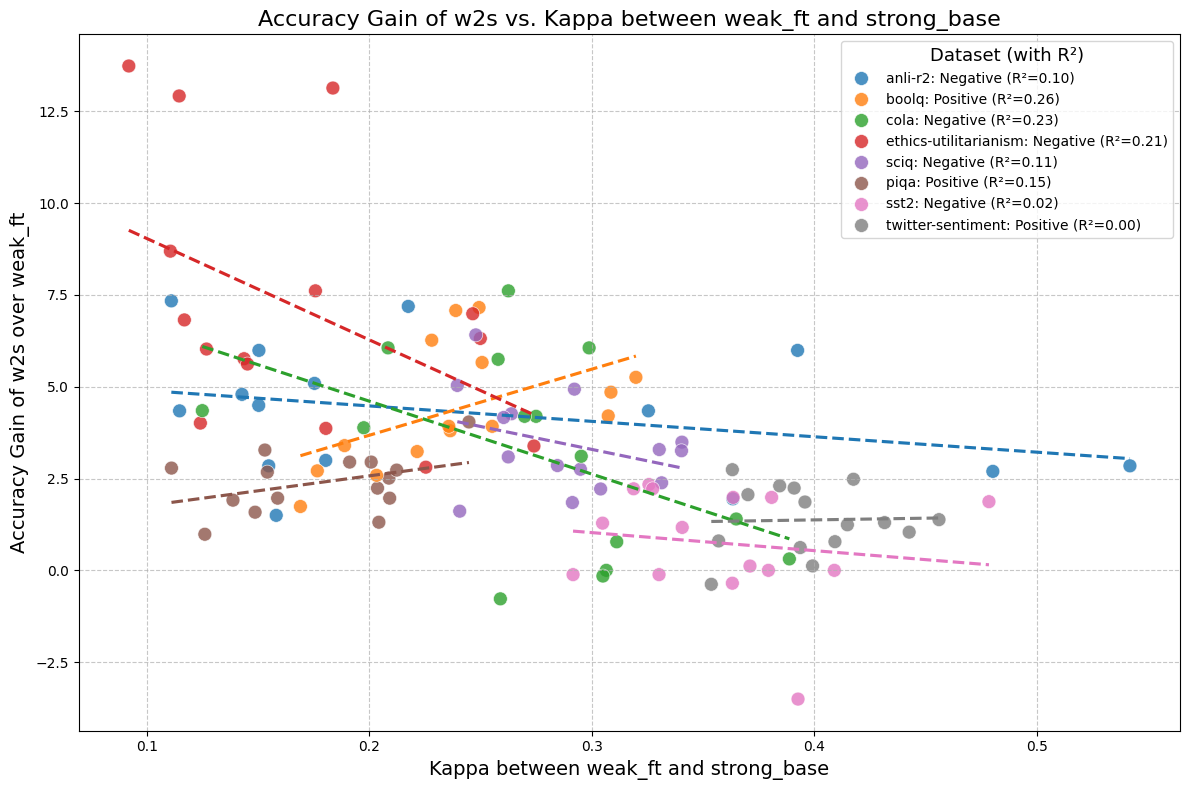

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


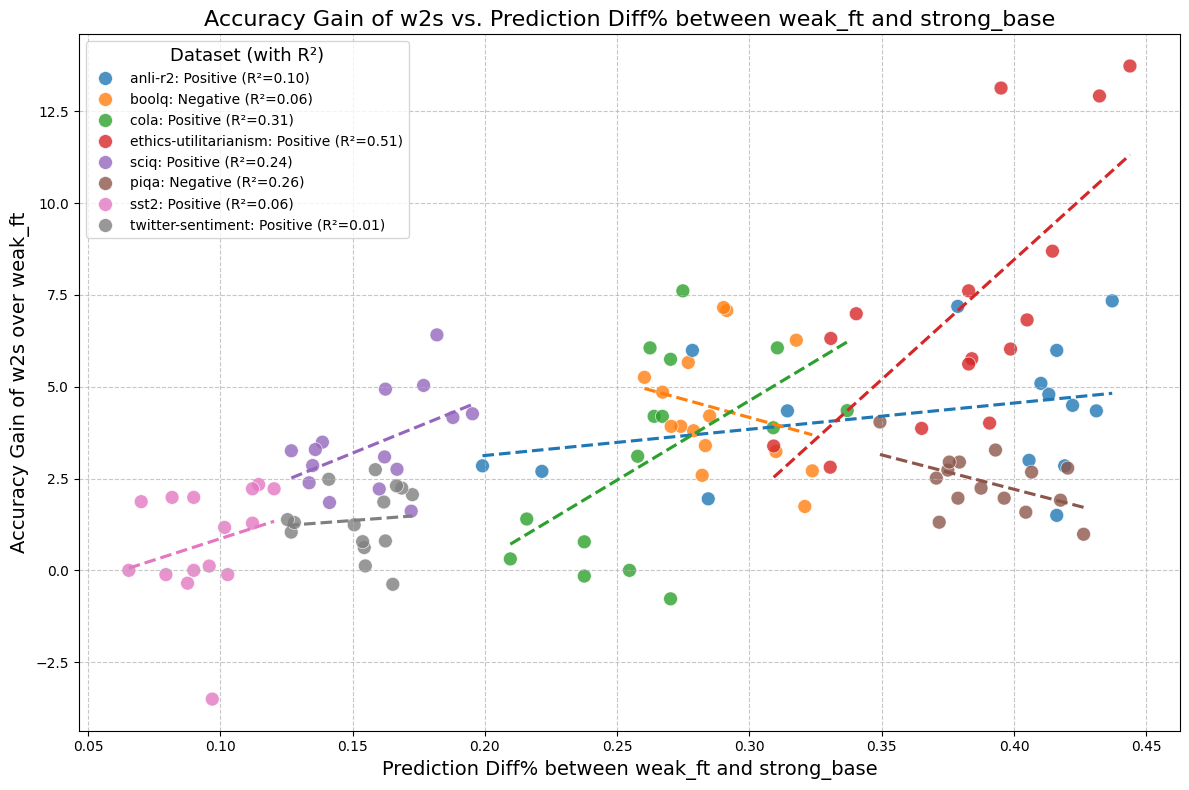

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


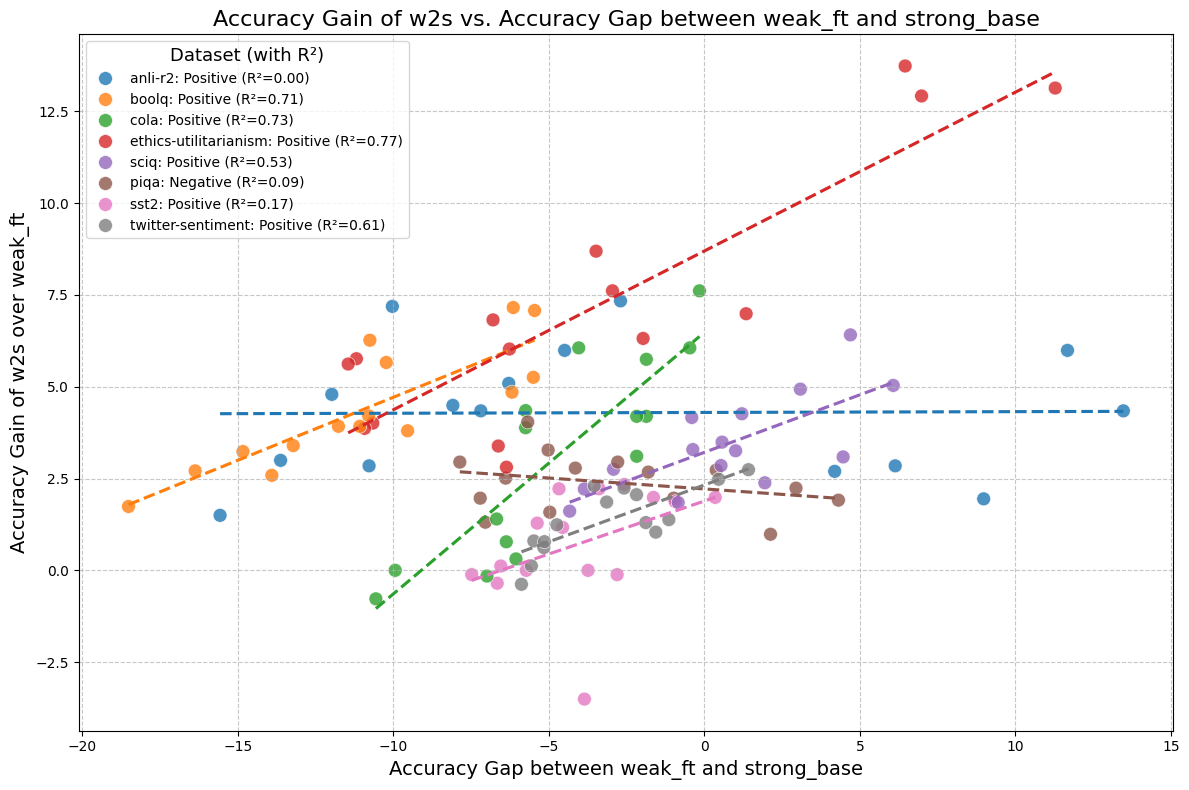

In [26]:
for metric_func, metric_name in zip([get_jsd, get_kappa_mcqs, get_diffp, _], ["JSD", "Kappa", "Prediction Diff%", "Accuracy Gap"]):
    w2sgain, diff, labels, weak_models, strong_models, accuracy_gap = [], [], [], [], [], []
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        print(f"Models: {weak_model}, {strong_model}")
        acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
        w2sgain, diff, labels, weak_models, strong_models, accuracy_gap = scatter_diff_w2sgain_datasets(
            acc_test, diffs_test[metric_name][(weak_model, strong_model)], datasets, "weak_ft", "strong_base", "w2s", "strong_ft", False, w2sgain, diff, labels, weak_models, strong_models, accuracy_gap, weak_model_name=weak_model, strong_model_name=strong_model
        )
    # Create DataFrame
    df = pd.DataFrame({
        'Difference': diff,
        'W2SGain': w2sgain,
        'Label': labels,
        'WeakModel': weak_models,
        'StrongModel': strong_models,
        'AccuracyGap': accuracy_gap
    })


    # Call the plotting function with residuals
    make_clean_scatter_plot_datasets(
        df['Difference'].tolist(),
        df['W2SGain'].tolist(),
        df['Label'].tolist(),
        metric_name,
        df['WeakModel'].tolist(),
        df['StrongModel'].tolist(),
        model_short_form
    )